## Abdominal CT Survey Questions 
Author: 楊晴雯 CHING- WEN YANG P76114511
### 🥕 References
- [Question/Ans Type Table](https://www.nature.com/articles/sdata2018251/tables/2)


### 🥕 Ratio 
1. 去研究 train, test set 中腹部 CT（或全部四種分類）的佔比與他對應的問題類型（Question Type）比例。
    
    A: CT 腹部 train:test = 999:158
    For question type distribution, "POS", "PRES", "ABN" 是比較常見的 Question Types。
    看下面的 bar chart。

2. 研究 inference 檔中，四個模態的圖像＋對應的問題 Type 的數量，和答對率。

    發現了原本的 code 內 indexing 的 bug (fixed)。
    A: 看 [spreadsheet](https://docs.google.com/spreadsheets/d/1cRwAqq9d2mgeTslEvs8pRsE1Q1Tq44PuXunuC8uU4fk/edit?usp=sharing)。
### 🥕 Basic Preprocessing 
1. 是否有一個 general的 basic CT 處理法？ 考慮 noise removal。
2. 部位-specific 來看，腹部的 CT 是否有統一的處理法 
3. 如果腹部 CT要看不同結構（eg. 軟組織，液體，...）的話，會怎麼處理？問題中有包含這種對不同結構的觀察嗎？
4. Presence, Positional Reasoning 類問題答錯特別多，這兩類內 Abdominal CT 的比例是多少？
5. （Extra）有辦法對 medical images 做 Object Detection 嗎（如果有現成訓練好的醫學領域 Obj Detect 模型的話，對 Presence 類 和 Positional 的 Question Types 或許有效，可以從詞彙類型來解決。只是這樣不太算是 medical image preprocessing）。
- [Hackmd](https://hackmd.io/@NanaEilish727/medvqa)

In [2]:
qcr_dir = 'PubMedCLIP/QCR_PubMedCLIP'
data_dir = 'PubMedCLIP/QCR_PubMedCLIP/data/data_rad'
imagedir = f'{data_dir}/images'
result_dir = 'PubMedCLIP/QCR_PubMedCLIP/results'

In [3]:
from typing import Union, List, Dict  
from pathlib import Path 
import pandas as pd 

def load_json(fp: Union[str, Path]):
    import json
    with open(fp, 'r') as f:
        return json.load(f)

def to_dataframe(data: List[Dict]):
    # data: List of dicts 
    # to data frame
    df = pd.DataFrame(data)
    return df 

In [4]:
# check data in testfile 
trainset = load_json(Path(data_dir)/"trainset.json") 
testset = load_json(Path(data_dir)/"testset.json")
trainset = to_dataframe(trainset)
testset = to_dataframe(testset) 

## Apply @Liu's modality label to the dataset 

In [5]:
# merge labeling information into train, test sets 
label_mod = pd.read_csv(f'{data_dir}/output2.csv')
def apply_modality(r):
    picid = r['image_name']
    mod = label_mod[label_mod['imageID']==picid]['class'].values[0]
    return mod
trainset['modality'] = trainset.apply(apply_modality, axis=1)
testset['modality'] = testset.apply(apply_modality, axis=1)

In [6]:
# save to csv 
# trainset.to_csv(f'{data_dir}/trainset.csv', index=False)
# testset.to_csv(f'{data_dir}/testset.csv', index=False)
# back to json 
# trainset = trainset.to_dict('records')
# testset = testset.to_dict('records')
# # save
# import json 
# with open(f'{data_dir}/trainset.json', 'w') as f:
#     json.dump(trainset, f, indent=4)
# with open(f'{data_dir}/testset.json', 'w') as f:
#     json.dump(testset, f, indent=4)

In [7]:
print(trainset['image_organ'].value_counts())
print(testset['image_organ'].value_counts())
# ABD has only type ct 

CHEST    1088
ABD       999
HEAD      977
Name: image_organ, dtype: int64
CHEST    174
ABD      158
HEAD     119
Name: image_organ, dtype: int64


In [8]:
# add new column 
def body_mod(r: pd.Series):
    return r['image_organ'] + '_' + r['modality']

trainset['body_mod'] = trainset.apply(body_mod, axis=1)
testset['body_mod'] = testset.apply(body_mod, axis=1)


In [9]:
bm_group_train = trainset.groupby("body_mod")
bm_group_test = testset.groupby("body_mod")
print('Train modality distribution:', bm_group_train.size())
print('Test modality distribution:', bm_group_test.size())


Train modality distribution: body_mod
ABD_CT          999
CHEST_X-Ray    1088
HEAD_CT         243
HEAD_MRI        734
dtype: int64
Test modality distribution: body_mod
ABD_CT         158
CHEST_X-Ray    174
HEAD_CT         31
HEAD_MRI        88
dtype: int64


/tmp/ipykernel_3779951/843752983.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


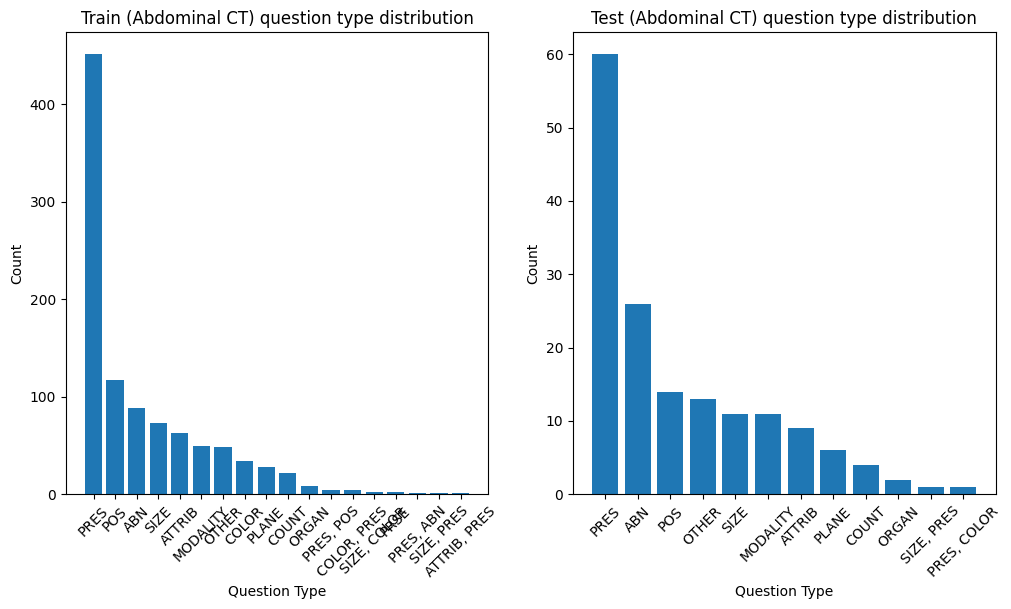

In [10]:
# check their question type 
abd_train_group = bm_group_train.get_group('ABD_CT')
abd_test_group = bm_group_test.get_group('ABD_CT')
import matplotlib.pyplot as plt

# Get the value counts of question types in the training and testing sets
train_counts = abd_train_group['question_type'].value_counts()
test_counts = abd_test_group['question_type'].value_counts()

# Create subplots for the bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar chart for the training set
ax1.bar(train_counts.index, train_counts.values)
ax1.set_title('Train (Abdominal CT) question type distribution')

# Plot the bar chart for the testing set
ax2.bar(test_counts.index, test_counts.values)
ax2.set_title('Test (Abdominal CT) question type distribution')

# Set the x-axis and y-axis labels for the subplots
for ax in [ax1, ax2]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Question Type')
    ax.set_ylabel('Count')

# Show the subplots
plt.show()

In [50]:
## Open test results 
test_results = pd.read_csv(f'{result_dir}/inference_testset.csv')  
test_results['body_mod'] = test_results.apply(body_mod, axis=1)
# correct, incorrect 
def check_eq(r: pd.Series):
    a = r['answer']
    p = r['pred_answer']
    a = a.lower()
    p = p.lower()
    return a==p

test_results['correct'] = test_results.apply(check_eq, axis=1)
# check the distribution of question type
cta_only = test_results[test_results['body_mod']=='ABD_CT']


In [51]:
# ct_only by-question type correct count 
totals = cta_only['question_type'].value_counts()
accs = cta_only.groupby('question_type')['correct'].sum()
# put into dataframe
cta_only_acc = pd.DataFrame({'total': totals, 'correct': accs, 'accuracy': accs/totals})
cta_only_acc = cta_only_acc.sort_values(by='total', ascending=False)
cta_only_acc

,total,correct,accuracy
PRES,60,42,0.700000
ABN,26,15,0.576923
POS,14,3,0.214286
OTHER,13,2,0.153846
MODALITY,11,7,0.636364
SIZE,11,10,0.909091
ATTRIB,9,7,0.777778
PLANE,6,4,0.666667
COUNT,4,1,0.250000
ORGAN,2,2,1.000000


In [52]:
# convert csv to json 
# test_results = test_results.to_dict('records')
# import json
# with open(f'{result_dir}/inference_testset.json', 'w') as f:
#     json.dump(test_results, f, indent=4)

In [53]:
# make a dataframe that is grouped by mod CT and question_type
ct_only = test_results[test_results['modality']=='CT']
# sort by question type and correct 
ct_only = ct_only.sort_values(['question_type', 'correct'])
# reset index
ct_only = ct_only.reset_index(drop=True)
ct_only.to_csv(f'{result_dir}/ct_only_inference_testset.csv', index=False)






In [54]:
ct_only['body_mod'].value_counts()

ABD_CT     158
HEAD_CT     31
Name: body_mod, dtype: int64

In [56]:
# Make trainset csv 
trainset.to_csv(f'{data_dir}/trainset.csv', index=False)